In [4]:
!ls "sample_data"

anscombe.json		      mmmm.mov		     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [5]:
!python -m pip install librosa

In [6]:
!pip install pydub

In [7]:
from pydub import AudioSegment
from pydub.utils import mediainfo
import scipy
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython import display
import IPython.display as ipd
import os
from typing import Tuple

In [56]:
file_path = "sample_data/mmmm.mov"


# Reading file and preprocessing

In [57]:
def load_audio_file(file_path, target_sr=22050):
    """
    Load audio file

    Parameters:
    -----------
    file_path : str
        Path to audio file
    target_sr : int, default=22050
        Target sample rate

    Returns:
    --------
    audio_data : np.ndarray
        Audio data
    sample_rate : int
        Sample rate
    """
    # Load audio file using pydub
    audio_segment = AudioSegment.from_file(file_path)

    # Convert to numpy array
    raw_audio_data = np.array(audio_segment.get_array_of_samples())

    # Handle stereo to mono conversion
    if audio_segment.channels == 2:
        raw_audio_data = raw_audio_data.reshape((-1, 2))
        raw_audio_data = raw_audio_data.mean(axis=1)

    # Normalize to [-1, 1] range
    audio_data = raw_audio_data.astype(np.float32) / (2**15)
    sample_rate = audio_segment.frame_rate

    # Resample to target sample rate
    if sample_rate != target_sr:
        audio_data = librosa.resample(audio_data, orig_sr=sample_rate, target_sr=target_sr)
        sample_rate = target_sr

    print(f"Audio loaded successfully, sample rate: {sample_rate}, duration: {len(audio_data)/sample_rate:.2f} seconds")

    return audio_data, sample_rate

audio_data, sample_rate = load_audio_file(file_path)

Audio loaded successfully, sample rate: 22050, duration: 4.13 seconds


In [58]:
def save_audio_file(audio_data: np.ndarray, sample_rate: int, output_path: str, format: str = "wav") -> None:
    """
    Save audio data to file

    Parameters:
    -----------
    audio_data : np.ndarray
        Audio data array
    sample_rate : int
        Sample rate of the audio
    output_path : str
        Output file path
    format : str, default="wav"
        Output format (wav, mp3, flac, etc.)
    """
    # Convert normalized audio back to int16
    audio_int16 = (audio_data * (2**15)).astype(np.int16)

    # Create AudioSegment from numpy array
    audio_segment = AudioSegment(
        audio_int16.tobytes(),
        frame_rate=sample_rate,
        sample_width=2,  # 16-bit
        channels=1       # mono
    )

    # Export to file
    audio_segment.export(output_path, format=format)
    print(f"Audio saved to: {output_path}")


def display_audio(samples: np.ndarray, sample_rate: int) -> None:
    """
    Display audio using IPython's Audio widget.

    Args:
        samples (np.ndarray): Audio samples.
        sample_rate (int): Sample rate of the audio.
    """
    ipd.display(ipd.Audio(samples, rate=sample_rate))

display_audio(audio_data, sample_rate)
save_audio_file(audio_data, sample_rate, "output1.wav")

Audio saved to: output1.wav


In [11]:
audio_data.shape, sample_rate

((91136,), 22050)

In [12]:
def get_audio_file_info(file_path: str) -> None:
    """
    Get and display audio file information

    Parameters:
    -----------
    file_path : str
        Path to audio file
    """
    # Get media info
    info = mediainfo(file_path)

    # Calculate file size
    file_size_bytes = float(info['size'])
    file_size_kb = file_size_bytes / 1024
    file_size_mb = file_size_kb / 1024

    # Choose appropriate unit based on size
    if file_size_mb >= 1:
        size_str = f"{file_size_mb:.2f} MB"
    else:
        size_str = f"{file_size_kb:.2f} KB"

    # Get filename without path
    filename = os.path.basename(file_path)

    # Display formatted info
    msg = f"""  file name          : {filename}
  file size          : {size_str}
  audio duration     : {info['duration']} seconds
  sample rate        : {info['sample_rate']} Hz
  audio channels     : {info['channels']}"""

    print(msg)

get_audio_file_info(file_path)

  file name          : mmmm.mov
  file size          : 38.39 KB
  audio duration     : 4.118000 seconds
  sample rate        : 22050 Hz
  audio channels     : 1


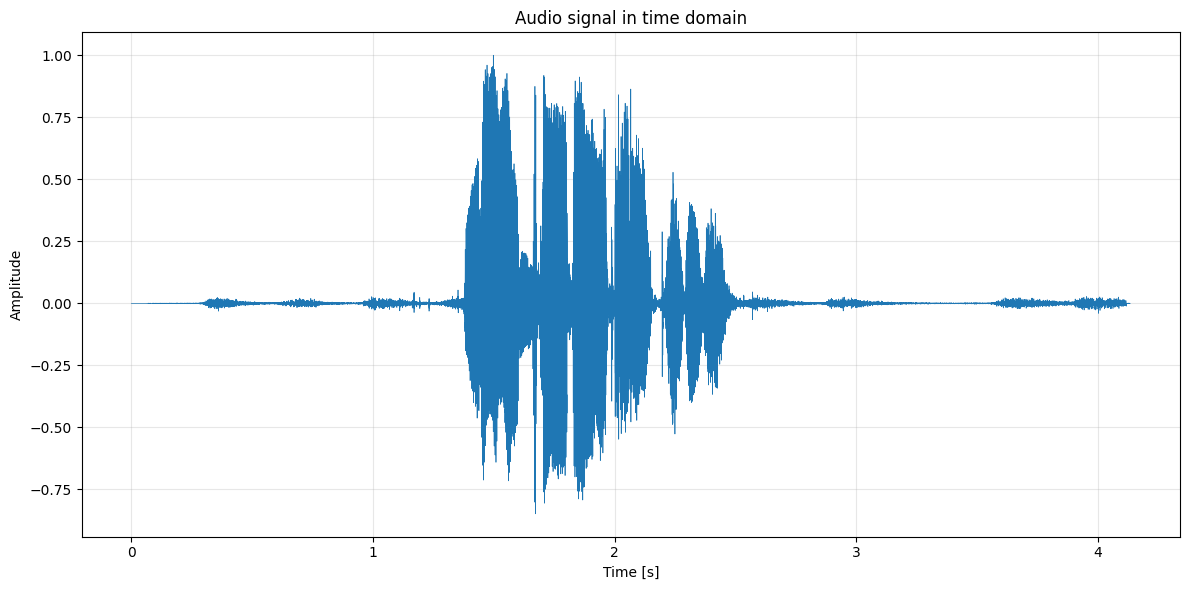

In [17]:
def plot_audio_waveform(audio_data: np.ndarray, sample_rate: int, normalize: bool = True,
                       title: str = "Audio signal in time domain", figsize: tuple = (12, 6)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Plot audio waveform in time domain and return processed samples and timeline

    Parameters:
    -----------
    audio_data : np.ndarray
        Audio samples array
    sample_rate : int
        Sample rate of the audio
    normalize : bool, default=True
        Whether to normalize the amplitude
    title : str, default="Audio signal in time domain"
        Plot title
    figsize : tuple, default=(12, 6)
        Figure size (width, height)

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (processed audio samples, timeline array)
    """
    # Calculate duration
    duration = len(audio_data) / sample_rate

    # Normalize samples if requested
    if normalize and np.max(np.abs(audio_data)) > 0:
        samples = audio_data / np.max(np.abs(audio_data))
    else:
        samples = audio_data

    # Create time axis
    timeline = np.linspace(0, duration, len(audio_data))

    # Create plot
    plt.figure(figsize=figsize)
    plt.plot(timeline, samples, linewidth=0.5)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return samples, timeline

samples, timeline = plot_audio_waveform(audio_data, sample_rate)

# VAD - Voice Activity Detection

- threshold based

vad_T: 0.001667018630541861, v_window: 911


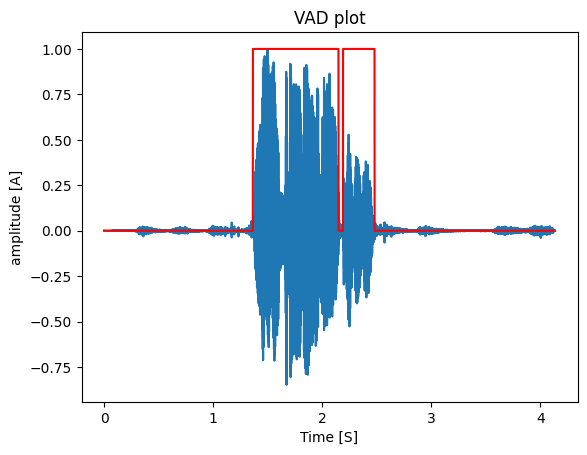

In [19]:
def voice_activity_detection(samples: np.ndarray, timeline: np.ndarray,
                            weight: float = 0.1, window_ratio: float = 0.01,
                            plot: bool = True, figsize: tuple = (12, 6)) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Perform voice activity detection on audio samples

    Parameters:
    -----------
    samples : np.ndarray
        Audio samples array
    timeline : np.ndarray
        Time axis array
    weight : float, default=0.1
        Weight parameter for threshold calculation
    window_ratio : float, default=0.01
        Window size as ratio of total samples (0.01 = 1%)
    plot : bool, default=True
        Whether to plot the results
    figsize : tuple, default=(12, 6)
        Figure size for plotting

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray, float]
        (VAD array, reference indices, threshold value)
    """
    # Initializing variables
    v_window = int(window_ratio * len(samples))  # window size
    vad_T = np.mean(samples**2) * weight  # threshold

    # Print threshold and window size info
    print(f"vad_T: {vad_T}, v_window: {v_window}")

    # Voice activity detection
    vad = np.zeros(shape=samples.shape)
    ref_idx = []

    for s_set in range(0, len(samples) - v_window, v_window):
        win_samples = samples[s_set:(s_set + v_window)]
        s_T = np.mean(win_samples**2)
        if s_T > vad_T:
            vad[s_set:(s_set + v_window)] = 1.0
            ref_idx.append(s_set)
        else:
            vad[s_set:(s_set + v_window)] = 0.0

    # Plotting audio samples
    if plot:
        plt.plot(timeline, samples)
        plt.plot(timeline, vad, color='red')
        plt.title("VAD plot")
        plt.xlabel("Time [S]")
        plt.ylabel("amplitude [A]")
        plt.show()

    return vad, np.array(ref_idx), vad_T

vad, ref_indices, threshold = voice_activity_detection(samples, timeline)

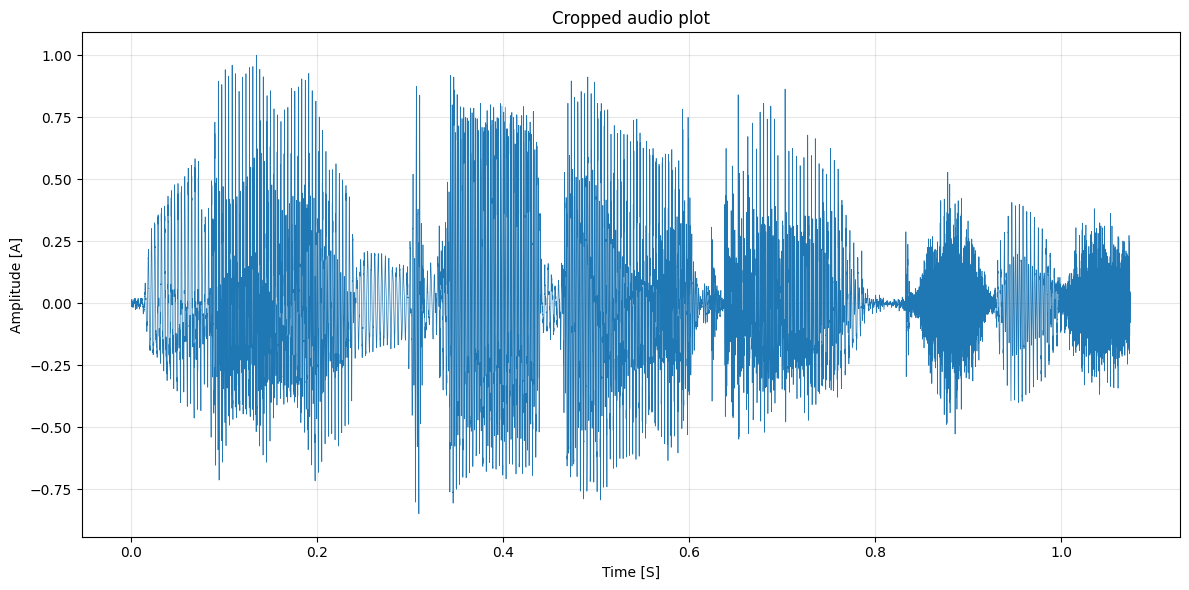

In [32]:
def crop_audio_by_vad(samples: np.ndarray, ref_indices: np.ndarray, sample_rate: int,
                      title: str = "Cropped audio plot", figsize: tuple = (12, 6),
                      plot: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Crop audio samples based on VAD reference indices and plot the result

    Parameters:
    -----------
    samples : np.ndarray
        Original audio samples array
    ref_indices : np.ndarray
        Reference indices from VAD detection
    sample_rate : int
        Sample rate of the audio
    title : str, default="Cropped audio plot"
        Plot title
    figsize : tuple, default=(12, 6)
        Figure size (width, height)
    plot : bool, default=True
        Whether to plot the cropped audio

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (cropped audio samples, cropped timeline array)
    """
    # Cropping audio only across VAD timeline
    new_samples = samples[min(ref_indices) : max(ref_indices)]

    # Create new timeline for cropped audio
    new_timeline = np.linspace(0, len(new_samples)/sample_rate, len(new_samples))

    # Plotting cropped audio samples
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(new_timeline, new_samples, linewidth=0.5)
        plt.title(title)
        plt.xlabel("Time [S]")
        plt.ylabel("Amplitude [A]")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return new_samples, new_timeline

new_samples, new_timeline = crop_audio_by_vad(samples, ref_indices, sample_rate)

In [39]:
display_audio(new_samples, sample_rate)
save_audio_file(new_samples, sample_rate, "output2.wav")

Audio saved to: output2.wav


# Pre-emphasis


Original signal shape: (23686,)
Pre-emphasized signal shape: (23686,)


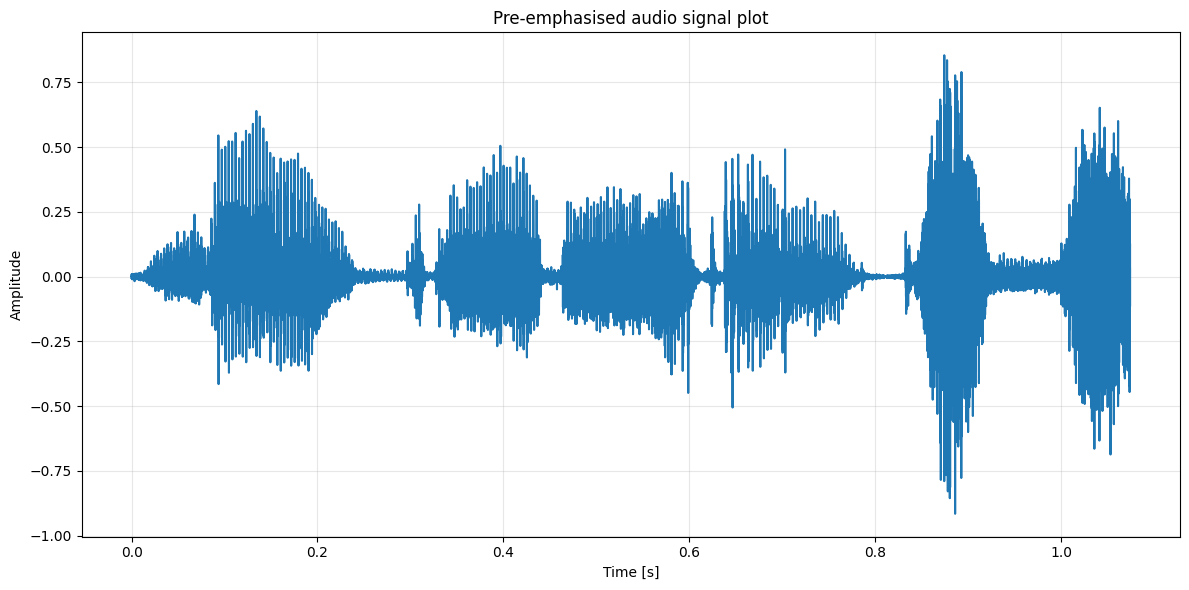

In [37]:
def pre_emphasize_audio(samples: np.ndarray, timeline: np.ndarray,
                       pre_emphasis: float = 0.97,
                       title: str = "Pre-emphasised audio signal plot",
                       plot: bool = True, figsize: tuple = (12, 6)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply pre-emphasis filter to audio samples

    Parameters:
    -----------
    samples : np.ndarray
        Audio samples array
    timeline : np.ndarray
        Time axis array
    pre_emphasis : float, default=0.97
        Pre-emphasis coefficient (typically 0.95-0.97)
    title : str, default="Pre-emphasised audio signal plot"
        Plot title
    plot : bool, default=True
        Whether to plot the results
    figsize : tuple, default=(12, 6)
        Figure size for plotting

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (pre-emphasized samples, timeline array)
    """
    # Pre-emphasising audio signal
    emphasized_signal = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

    # Print shape information
    print(f"Original signal shape: {samples.shape}")
    print(f"Pre-emphasized signal shape: {emphasized_signal.shape}")

    # Plotting pre-emphasized audio signal
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(timeline, emphasized_signal)
        plt.title(title)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return emphasized_signal, timeline

emphasized_samples, timeline = pre_emphasize_audio(new_samples, new_timeline)

In [40]:
display_audio(emphasized_samples, sample_rate)
save_audio_file(emphasized_samples, sample_rate, "output3.wav")

Audio saved to: output3.wav


# fast fourier transform (FFT) - (time domain to frequency domain)


Frequency: 5 Hz
Samples: 100
Signal shape: (100,)


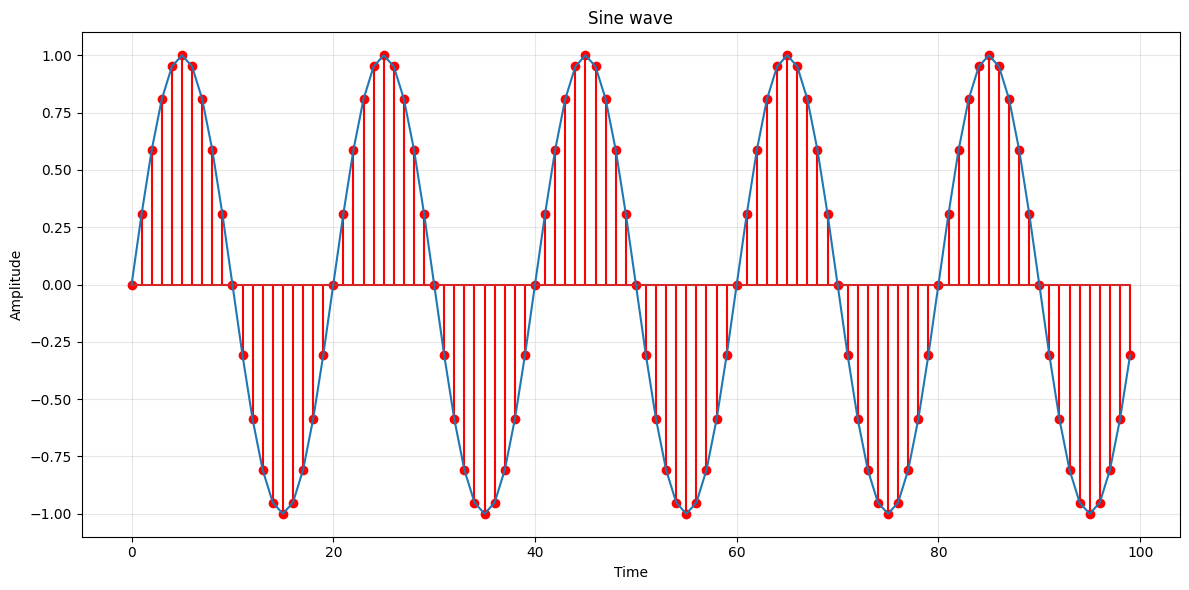

In [42]:
def generate_sine_wave(frequency: float = 5, samples: int = 100,
                      title: str = "Sine wave", plot: bool = True,
                      figsize: tuple = (12, 6), show_stem: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate and plot a basic sine wave

    Parameters:
    -----------
    frequency : float, default=5
        Frequency of the sine wave
    samples : int, default=100
        Number of samples
    title : str, default="Sine wave"
        Plot title
    plot : bool, default=True
        Whether to plot the results
    figsize : tuple, default=(12, 6)
        Figure size for plotting
    show_stem : bool, default=True
        Whether to show stem plot along with line plot

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (time array, sine wave amplitude array)
    """
    # Basic sine wave generation
    x = np.arange(samples)
    y = np.sin(2*np.pi*frequency*(x/samples))

    # Print wave information
    print(f"Frequency: {frequency} Hz")
    print(f"Samples: {samples}")
    print(f"Signal shape: {y.shape}")

    # Plotting sine wave
    if plot:
        plt.figure(figsize=figsize)
        if show_stem:
            plt.stem(x, y, 'r')
        plt.plot(x, y)
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return x, y

x, y = generate_sine_wave()

In [46]:
def plot_fft(signal: np.ndarray, sample_rate: int,
             title: str = "FFT plot", plot: bool = True,
             figsize: tuple = (12, 6)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute and plot FFT of the signal

    Parameters:
    -----------
    signal : np.ndarray
        Input signal array
    sample_rate : int
        Sample rate of the signal
    title : str, default="FFT plot"
        Plot title
    plot : bool, default=True
        Whether to plot the results
    figsize : tuple, default=(12, 6)
        Figure size for plotting

    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (frequency array, FFT magnitude array)
    """
    # Compute FFT
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sample_rate)
    fft_magnitude = np.abs(fft_spectrum)

    # Print FFT information
    print(f"Signal length: {signal.size}")
    print(f"FFT spectrum shape: {fft_spectrum.shape}")
    print(f"Frequency range: 0 - {freq[-1]:.2f} Hz")

    # Plotting FFT
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(freq, fft_magnitude, c='b')
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return freq, fft_magnitude


Signal length: 100
FFT spectrum shape: (51,)
Frequency range: 0 - 50.00 Hz


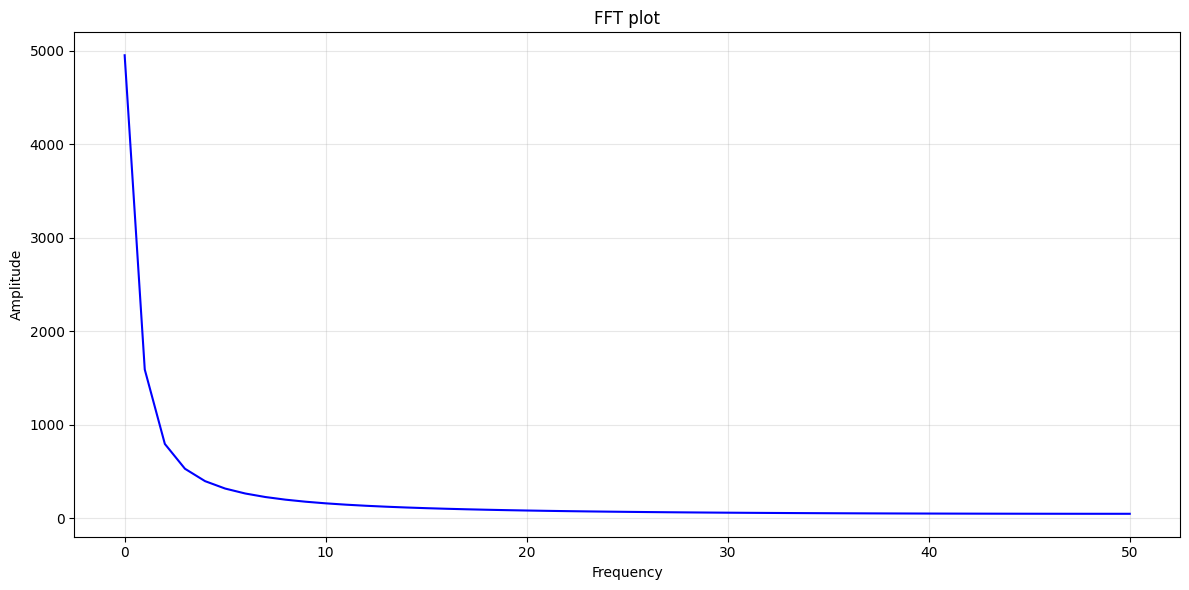

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 array([4950.        , 1591.81126045,  796.2985555 ,  531.30268981,
         398.93648778,  319.62266107,  266.83557061,  229.20719285,
         201.05361167,  179.21718262,  161.80339887,  147.60673964,
         135.82359458,  125.89768492,  117.4317328 ,  110.13446323,
         103.78748038,   98.22383494,   93.31373584,   88.95477427,
          85.06508084,   81.57843788,   78.44072518,   75.60729305,
          73.04099246,   70.71067812,   68.5900574 ,   66.65679527,
          64.89181136,   63.2787228 ,   61.80339887,   60.45360217,
          59.21869749,   58.08941405,   57.05765018,   56.11631188,
          55.25917894,   54.48079323,   53.77636535,   53.14169622,
          52.57311121,   52.067

In [48]:
plot_fft(x, 100)

Signal length: 91136
FFT spectrum shape: (45569,)
Frequency range: 0 - 11025.00 Hz


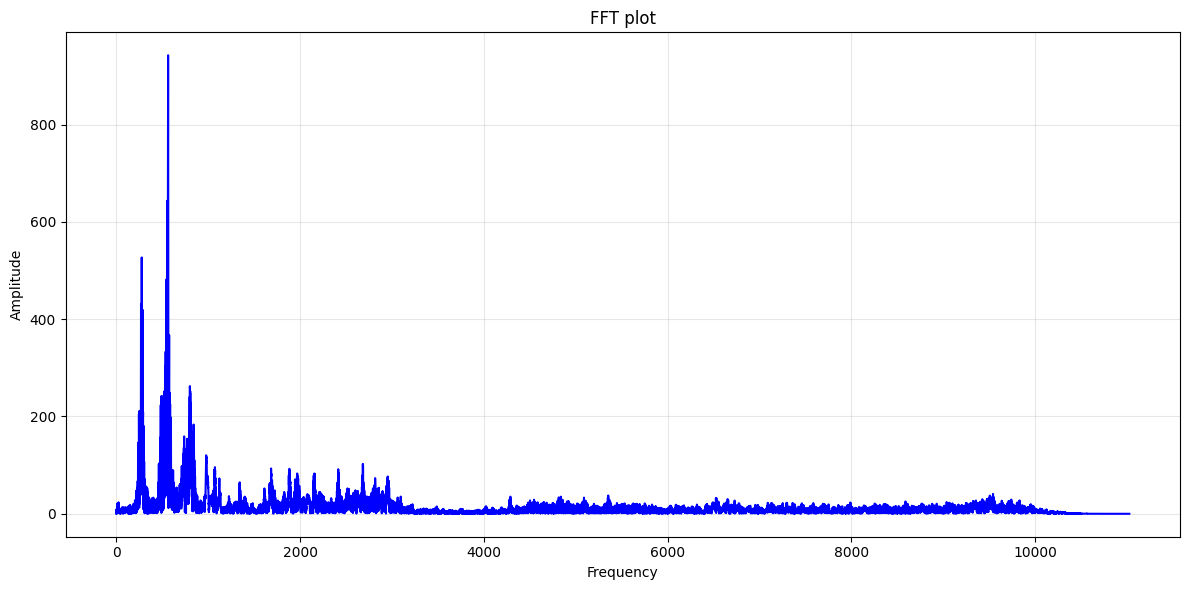

(array([0.00000000e+00, 2.41946103e-01, 4.83892205e-01, ...,
        1.10245161e+04, 1.10247581e+04, 1.10250000e+04]),
 array([3.7857056e-01, 5.4681664e+00, 7.1191058e+00, ..., 4.7037359e-03,
        3.9481558e-03, 8.7585449e-03], dtype=float32))

In [49]:
plot_fft(audio_data, sample_rate)

# Sampling or Framing Audio signal

In [50]:
f_d = 0.0065
n_f = len(samples)
f_size = int(np.round(n_f * f_d))
print("frame duration: ", f_d, ", number of frames: ", n_f, ", frame size: ", f_size)

frame duration:  0.0065 , number of frames:  91136 , frame size:  592


In [51]:
frames = []

for i in range(0, (n_f-f_size), f_size):
  frame = samples[i:i+f_size]
  frames.append(frame)

frames = np.asarray(frames)
frames.shape

(153, 592)

In [60]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_frame_animation(frames: np.ndarray, f_size: int,
                          interval: int = 50, fps: int = 20,
                          save_path: str = "frame.gif", dpi: int = 300,
                          title: str = "Frame Animation",
                          figsize: tuple = (12, 6),
                          save_gif: bool = True, show_video: bool = True) -> object:
    """
    Create and save animation from frame data

    Parameters:
    -----------
    frames : np.ndarray
        Frame data array with shape (n_frames, frame_size)
    f_size : int
        Size of each frame
    interval : int, default=50
        Delay between frames in milliseconds
    fps : int, default=20
        Frames per second for saved animation
    save_path : str, default="frame.gif"
        Path to save the GIF file
    dpi : int, default=300
        DPI for saved animation
    title : str, default="Frame Animation"
        Animation title
    figsize : tuple, default=(12, 6)
        Figure size for animation
    save_gif : bool, default=True
        Whether to save animation as GIF
    show_video : bool, default=True
        Whether to display HTML5 video

    Returns:
    --------
    object
        FuncAnimation object
    """

    # Print animation information
    print(f"Frames shape: {frames.shape}")
    print(f"Frame size: {f_size}")
    print(f"Total frames: {frames.shape[0]}")
    print(f"Animation duration: {frames.shape[0] * interval / 1000:.2f} seconds")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    def animate(i):
        ax.clear()
        ax.set_xlim(0, f_size)
        ax.set_ylim(-1, 1)
        ax.set_title(f"{title} - Frame {i+1}/{frames.shape[0]}")
        ax.set_xlabel("Sample")
        ax.set_ylabel("Amplitude")
        ax.grid(True, alpha=0.3)
        line, = ax.plot(frames[i, :], color='blue', lw=1)
        return line,

    # Create animation
    ani = FuncAnimation(fig, animate, interval=interval, blit=True,
                       repeat=True, frames=frames.shape[0])

    # Save GIF
    if save_gif:
        ani.save(save_path, dpi=dpi, writer=PillowWriter(fps=fps))
        print(f"Animation saved as: {save_path}")

    # Display HTML5 video
    if show_video:
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)

    # Good practice to close the plt object
    plt.close()

    return ani

ani = create_frame_animation(frames, f_size)

Frames shape: (153, 592)
Frame size: 592
Total frames: 153
Animation duration: 7.65 seconds
Animation saved as: frame.gif


# Hann window function

In [69]:
def hanning(M):
    w = 0.54 - 0.46*np.cos(2*np.pi*np.arange(1, M+1)/(M-1))
    return w

wf = hanning(frames.shape[1])
wf.shape

(592,)

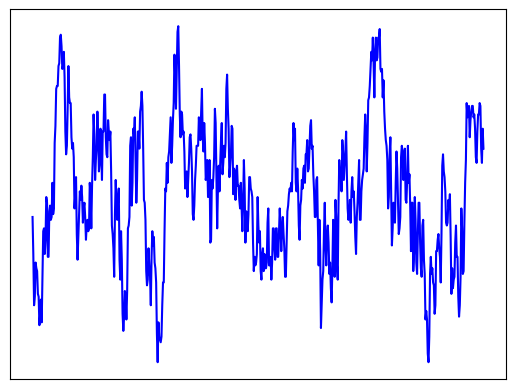

In [70]:

plt.plot(frames[126], c='b')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

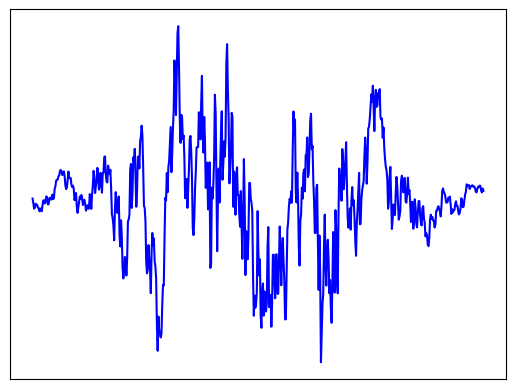

In [71]:

# plot example
fw = np.multiply(frames[126], wf)

plt.plot(fw, c='b')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [77]:
# appliying hanning to all frames
frame_W = []
for f in frames:
    frame_W.append(np.multiply(wf, f))
frame_W = np.array(frame_W)
frame_W.shape

(153, 592)

In [73]:

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_xlim(0,f_size)
    ax.set_ylim(-1,1)
    line, = ax.plot(frame_W[i, :], color = 'blue', lw=1)
    return line,

ani = FuncAnimation(fig, animate, interval=50, blit=True, repeat=True, frames=150)
ani.save("windows.gif", dpi=300, writer=PillowWriter(fps=20))

# live plot
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()


# spectrum plot

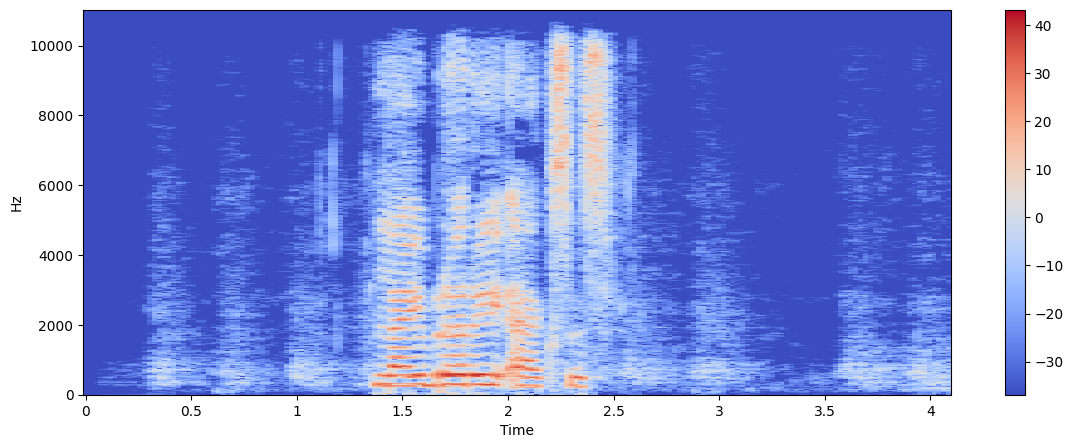

In [74]:
#display Spectrogram
X = librosa.stft(frame_W.ravel())
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
#If to pring log of frequencies
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

# MFCC - Mel-Frequency Cepstral Coefficients

- feature extraction.

- re-generate audio signal from MFCC